In [17]:
%load_ext autoreload
%autoreload 2
import datetime 
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from setdir import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Slocum gliders: Serial numbers
unit_list = ['unit_398', 'unit_409']

# Formatting string for date/time to use in filenaming
time_strf = '%Y%m%d'

# Name the file according to what date?
# Currently implemented: Date file was created
# Alternate option: end date of data record
yyyymmdd = datetime.datetime.now().strftime(time_strf)

# Time limits
datestart = '2021-12-12'
tstart = pd.Timestamp('2021-12-12T00')

# Initialise the figure directory
figdir = create_figdir()

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

In [19]:
# Load the latest data in
int_dir = cat_interim_path('')
unit_to_do = []

# Extract a list with the names of existing raw data files.
for i in unit_list:
    fname = i+'_*_edit.nc'
    existing_files = glob.glob(cat_interim_path(fname))

    if len(existing_files) > 0:
        existing_files = sorted(existing_files)
        end_date = (existing_files[-1])[-16:-8]
        t1 = datetime.datetime.strptime(end_date, time_strf)
        
        proc_files = glob.glob(cat_proc_path(fname))
        if len(proc_files) > 0:
            end_date_proc = (proc_files[-1])[-16:-8]
            t_proc = datetime.datetime.strptime(end_date_proc, time_strf)

            print(i+' - Previous file ended: '+t_proc+', New end: '+end_date)
            if t_proc < t1:
                unit_to_do.append(i)
        else:
            print(i+' - Need to process')
            unit_to_do.append(i)
            

unit_398 - Need to process
unit_409 - Need to process


In [79]:
presname = 'pressure_dbar'

# Load data and separate by climbing or diving
for i in unit_to_do:
    fname = i+'_*_edit.nc'
    existing_files = glob.glob(cat_interim_path(fname))
    
    existing_files = sorted(existing_files)
    ds_int = xr.open_dataset(existing_files[-1])
    
    pres = ds_int[presname]
    updn = np.zeros(len(pres), dtype='int')

    for i in range(len(pres)-1):
        inext = i+1
        pstart = pres[i]
        pnext = pres[inext]

        if pnext>pstart:
            updn[i] = -1
        else:
            updn[i] = 1
            
    ds_int['updn'] = ('time', updn)

KeyboardInterrupt: 

In [ ]:
ds_int

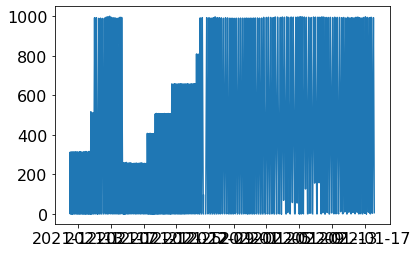

In [22]:
# Identifying separate profiles
timename = 'time'
presname = 'pressure_dbar'
plt.plot(ds_int[timename], ds_int[presname])

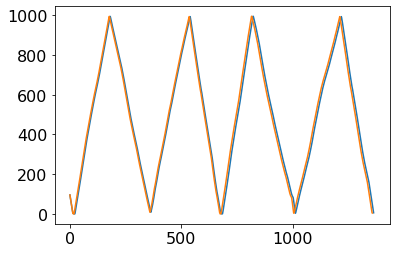

In [96]:
# Get a bit of recent data
ndays = 1
max_time = ds_int.time.max().values
dt1 = np.timedelta64(-ndays, 'D')
ds1 = ds_int.where(ds_int[timename]>=(max_time+dt1), drop=True)
plt.plot(ds1[presname])

maxp = ds1[presname].max().values
minp = ds1[presname].min().values
pres = ds1[presname].values
ds2 = ds1.where(~np.isnan(ds1[presname]), drop=True)
pres = ds2[presname].values
plt.plot(pres)

updn = np.zeros(len(pres), dtype='int')

for i in range(len(pres)-1):
    inext = i+1
    pstart = pres[i]
    pnext = pres[inext]
    
    if pnext>pstart:
        updn[i] = -1
    else:
        updn[i] = 1
        

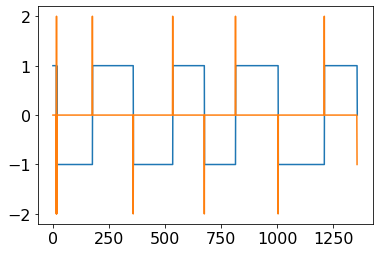

In [97]:
plt.plot(updn)
plt.plot(np.diff(updn))

In [104]:
# Try to identify times where the direction switched
inearbottom = (np.diff(updn)==2)
isurf = (np.diff(updn)==-2)
np.count_nonzero(inearbottom)
np.count_nonzero(isurf)
pres2 = pres[0:-1]

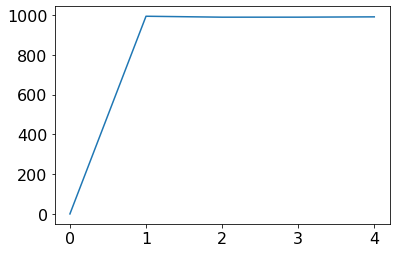

In [106]:
plt.plot(pres2[inearbottom])

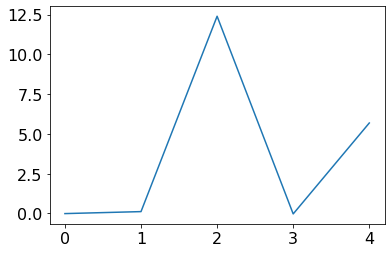

In [107]:
plt.plot(pres2[isurf])

In [90]:
len(inearbottom)

48976

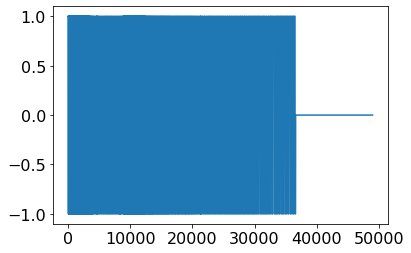

In [92]:
plt.plot(updn)